In [1]:
# import the libraries as shown below

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot  as plt
from keras.utils.vis_utils import plot_model
import visualkeras

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

#train_path = 'Datasets/train'
#valid_path = 'Datasets/test'

train_path = 'D:/project/CT/train'
valid_path = 'D:/project/CT/test'

In [4]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [5]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [6]:
# useful for getting number of output classes
folders = glob('D:/project/CT/train/*')

In [7]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)

In [8]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [9]:
# view the structure of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

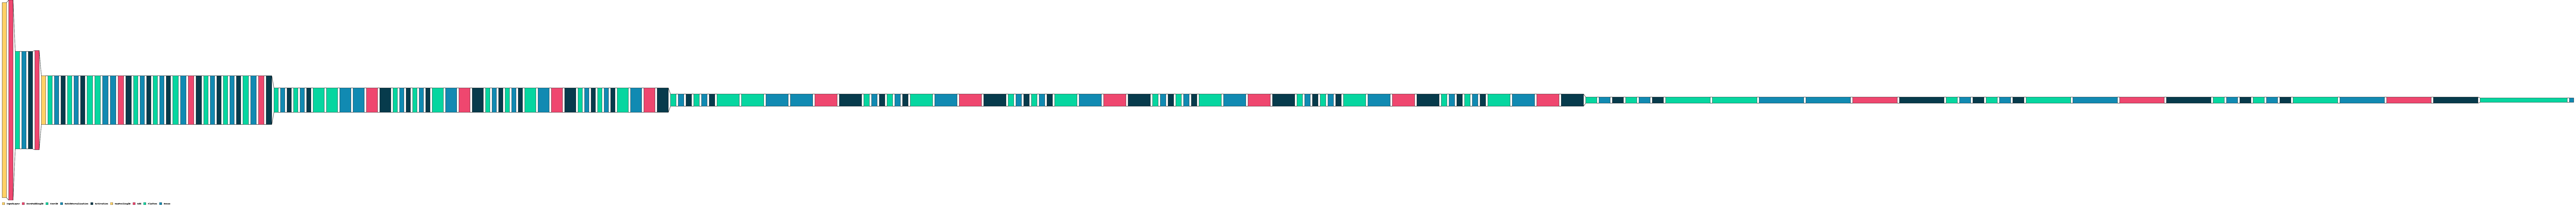

In [26]:
visualkeras.layered_view(model,legend=True, draw_volume=False).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model,legend=True, draw_volume=False)

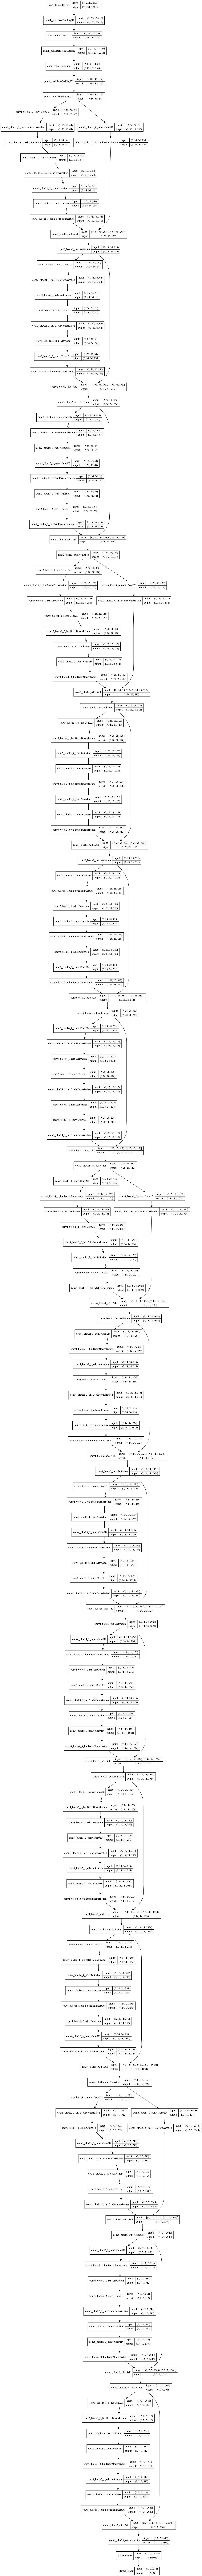

In [34]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir="TB",
    expand_nested=False,
    dpi=96,)

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [23]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [24]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('D:/project/CT/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5571 images belonging to 2 classes.


In [25]:
test_set = test_datagen.flow_from_directory('D:/project/CT/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 2500 images belonging to 2 classes.


In [26]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=3,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/3
175/175 [==============================] - 2492s 14s/step - loss: 0.9582 - accuracy: 0.7993 - val_loss: 0.6999 - val_accuracy: 0.7520
Epoch 2/3
175/175 [==============================] - 2483s 14s/step - loss: 0.3101 - accuracy: 0.8641 - val_loss: 0.6692 - val_accuracy: 0.7724
Epoch 3/3
175/175 [==============================] - 2381s 14s/step - loss: 0.4334 - accuracy: 0.8454 - val_loss: 1.0943 - val_accuracy: 0.7436


In [33]:
#Generate Data to validate with new data 
#non covid set
valid_set=test_datagen.flow_from_directory('D:/project/CT/val NC',
                                                target_size = (224, 224),
                                                batch_size = 32,
                                                class_mode = 'categorical')

Found 20 images belonging to 1 classes.


In [34]:
import numpy as np
pred=np.round(model.predict(valid_set))
#08 or 1
print(pred)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [36]:
#Generate Data to validate with new data 
#covid set
valid_set=test_datagen.flow_from_directory('D:/project/CT/val C',
                                                target_size = (224, 224),
                                                batch_size = 32,
                                                class_mode = 'categorical')

Found 20 images belonging to 1 classes.


In [37]:
import numpy as np
pred=np.round(model.predict(valid_set))
#08 or 1
print(pred)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [27]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

NameError: name 'r' is not defined